In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as pltcolors
import pandas as pd
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors as mcolors
from matplotlib import cm
import matplotlib.dates as mdates
from beautifultable import BeautifulTable
from datetime import datetime
from datetime import timedelta
import warnings
import matplotlib.ticker as mtick
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Media spend per House candidate
# https://mediaproject.wesleyan.edu/releases-102920/#table12
# Battleground races:
# https://ballotpedia.org/U.S._House_battlegrounds,_2020

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

def get_state_name_from_bg_column( state_str ):
    state_str = state_str.split( '\'' )
    state_str[ 1 ] = state_str[ 1 ].replace( '\'', '' )
    state_str[ 1 ] = state_str[ 1 ].replace( ' ', '' )
    if state_str[ 1 ][ 0 ] == 's':
        state_str[ 1 ] = state_str[ 1 ][ 1: ]
    state_str[ 0 ] = state_str[ 0 ].rstrip()
    return state_str #returns an array

def strip_state_ordinal( state_str ):
    ords = ['st', 'nd', 'rd', 'th' ]
    for o in ords:
        state_str = state_str.replace( o, '' )
    return state_str

def get_district_name_from_state( row ):
    state = us_state_abbrev[ get_state_name_from_bg_column( row[ 'dist' ] )[ 0 ] ]
    district = strip_state_ordinal( get_state_name_from_bg_column( row[ 'dist' ] )[ 1 ] )
    return state + '_' + district

def get_max_spend_value_for_seat( seat ):
    return house[ house[ 'seat' ] == seat ][ 'fbandg_since010619' ].max()

def get_max_spend_party_for_seat( seat, max_spend_value ):
    return house[ ( house[ 'seat' ] == seat ) & ( house[ 'fbandg_since010619' ] == max_spend_value ) ][ 'Party' ].values[ 0 ]

house = pd.read_excel( 
        open( 'house.xlsx', 'rb' ), sheet_name='Sheet1', 
        header=0 )
bg_house = pd.read_excel(
        open( 'bg_house.xlsx', 'rb' ), sheet_name = 'Sheet 1', 
            header = None )
bg_house = bg_house.iloc[:, :-2]

bg_house.columns = ['dist', 'rep', 'open_seat', '2018_margin']
bg_house = bg_house[:-1]

house = house.drop( ['tv_010119to102520', 'per_tvcycle', 'tv_101220to102520', 'per_tvsince1011'], axis=1 )

#only care about REP and DEM
house = house[ house[ 'Party' ].isin( [ 'REP', 'DEM' ] ) ]

house[ 'seat' ] = house[ 'State' ] + '_' + house[ 'District' ].astype( 'str' )

bg_house[ 'seat' ] = bg_house.apply( lambda row: get_district_name_from_state( row ), axis=1 )

house = pd.merge( left=house, right=bg_house, on='seat', how='left', suffixes=("_house", "_bg") )

house[ 'battleground' ] = house[ 'dist' ].apply( lambda x: True if isinstance( x, str ) else False )

#only take the top 2 from each race
house = house.sort_values( ['seat', 'fbandg_since010619'], axis=0, ascending=False).groupby('seat').head( 2 )
#re-sort by index
house.sort_index( inplace=True )

house[ 'max_spend_value' ] = house.apply( lambda x: get_max_spend_value_for_seat( x[ 'seat' ] ), axis=1 )
house[ 'max_spend_party' ] = house.apply( lambda x: get_max_spend_party_for_seat( x[ 'seat' ], x[ 'max_spend_value' ] ), axis=1 )
house[ 'diff_from_max' ] = house.apply( lambda x: x[ 'fbandg_since010619' ] - x[ 'max_spend_value' ] if x[ 'max_spend_value' ] != x[ 'fbandg_since010619' ] else 0, axis=1 ) 

dem = house[ ( house[ 'Party' ].isin( [ 'DEM' ] ) ) ].sort_values( 'seat', axis=0, ascending=False )
rep = house[ house[ 'Party' ].isin( [ 'REP' ] ) ].sort_values( 'seat', axis=0, ascending=False )

house.head()


,State,District,Party,Candidate,fbandg_since010619,fbandg_since101120,fec_id,seat,dist,rep,open_seat,2018_margin,battleground,max_spend_value,max_spend_party,diff_from_max
0,NY,21,REP,"Stefanik, Elise M.",744592,78593,H4NY21079,NY_21,NaN,NaN,NaN,NaN,False,744592,REP,0
1,TX,21,DEM,"Davis, Wendy",894569,287048,H0TX21148,TX_21,Texas' 21st,Chip Roy,No,R+2.6,True,894569,DEM,0
2,TX,2,REP,"Crenshaw, Daniel",227823,67628,H8TX02166,TX_2,NaN,NaN,NaN,NaN,False,227823,REP,0
3,NY,21,DEM,"Cobb, Tedra",228544,34958,H8NY21245,NY_21,NaN,NaN,NaN,NaN,False,744592,REP,-516048
5,NJ,7,DEM,"Malinowski, Tom",195249,35735,H8NJ07223,NJ_7,New Jersey's 7th,Tom Malinowski,No,D+5.0,True,263365,REP,-68116


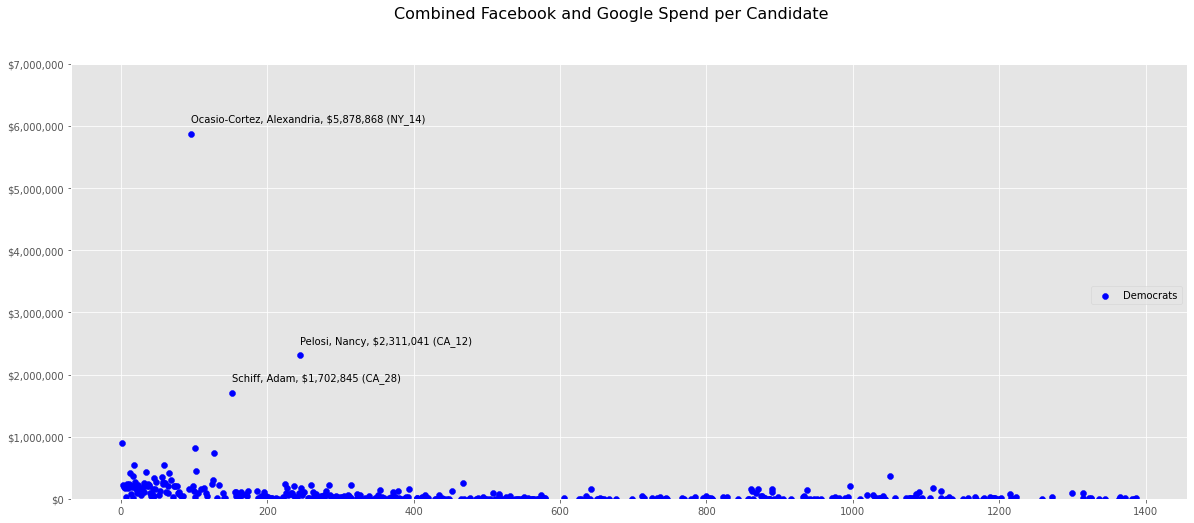

In [33]:
fig, ax1 = plt.subplots()
plt.rcParams[ 'figure.figsize' ] = [ 20, 8 ]

ax1.scatter( dem.index.tolist(), dem.fbandg_since010619.tolist(), color='blue', label='Democrats')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax1.set_ylim(0, 7000000)

fig.legend(loc=1, bbox_to_anchor=(1,0.5), bbox_transform=ax1.transAxes)
fig.suptitle( 'Combined Facebook and Google Spend per Candidate', fontsize=16 )

for index, row in dem.iterrows():
    if row.fbandg_since010619 > 1000000:
        amt = row[ 'fbandg_since010619' ]
        ax1.annotate( row.Candidate + ", $" + str( '{:,}'.format( amt ) ) + " (" + row.seat + ")", ( index, 200000+row[ 'fbandg_since010619' ] ) )

plt.show()

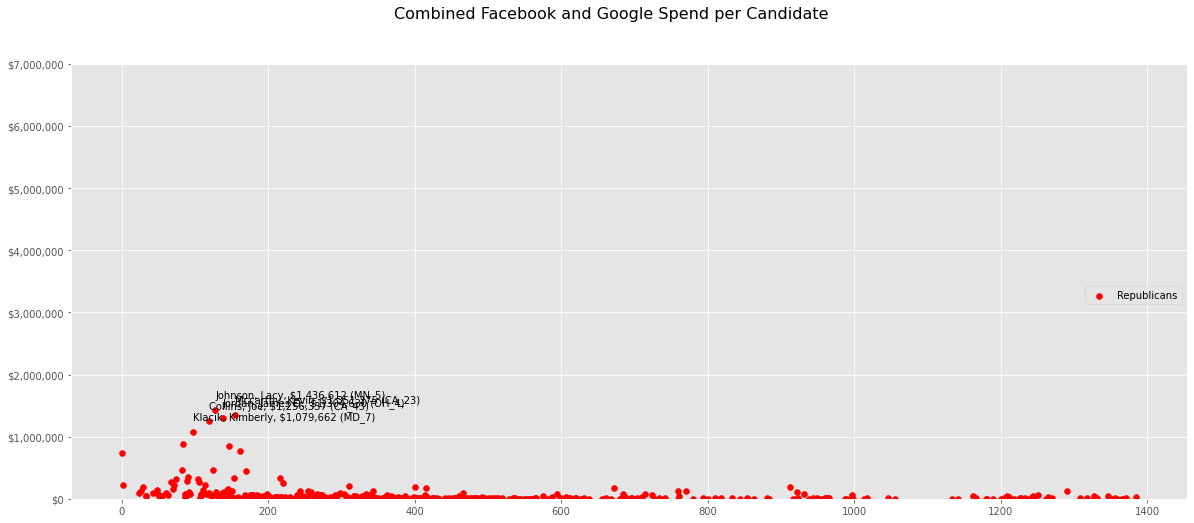

In [34]:
fig, ax1 = plt.subplots()
plt.rcParams[ 'figure.figsize' ] = [ 20, 8 ]

ax1.scatter( rep.index.tolist(), rep.fbandg_since010619.tolist(), color='red', label='Republicans')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax1.set_ylim(0, 7000000)

fig.legend(loc=1, bbox_to_anchor=(1,0.5), bbox_transform=ax1.transAxes)
fig.suptitle( 'Combined Facebook and Google Spend per Candidate', fontsize=16 )

for index, row in rep.iterrows():
    if row.fbandg_since010619 > 1000000:
        amt = row[ 'fbandg_since010619' ]
        ax1.annotate( row.Candidate + ", $" + str( '{:,}'.format( amt ) ) + " (" + row.seat + ")", ( index, 200000+row[ 'fbandg_since010619' ] ) )
        
plt.show()

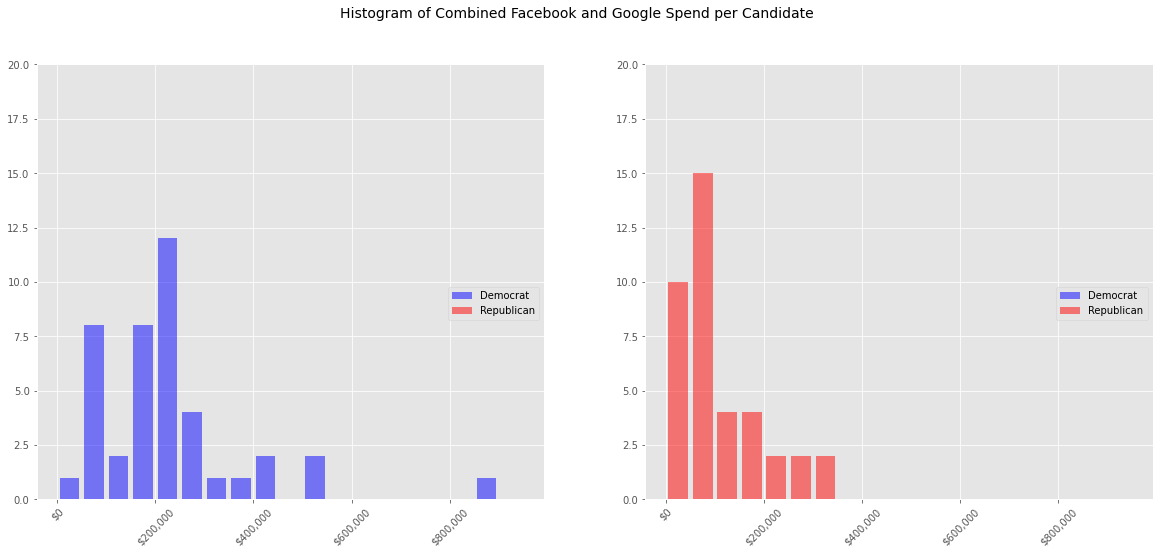

In [26]:
# house[ house[ 'Party' ].isin( ['REP', 'DEM' ] ) ].groupby( 'Party' ).fbandg_since010619.hist()
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter
import seaborn as sns

#remove AOC: ( house[ 'fec_id' ] != 'H8NY15148' ) &
house = house[ ( house[ 'battleground'] == True ) ]

dem = house[ ( house[ 'Party' ].isin( [ 'DEM' ] ) ) ].sort_values( 'seat', axis=0, ascending=False )
rep = house[ house[ 'Party' ].isin( [ 'REP' ] ) ].sort_values( 'seat', axis=0, ascending=False )

fig, ax1 = plt.subplots( nrows=1, ncols=2 )
plt.rcParams[ 'figure.figsize' ] = [ 20, 8 ]
plt.style.use('ggplot')

ax1[ 0 ].hist( dem[ 'fbandg_since010619' ], bins = range(0, 1000000, 50000), alpha=.5, rwidth=.8, color='blue', label='Democrat')
ax1[ 1 ].hist( rep[ 'fbandg_since010619' ], bins = range(0, 1000000, 50000), alpha=.5, rwidth=.8, color='red', label='Republican')

for i in range( 2 ):
    #ax1[ i ].xaxis.set_major_locator(MaxNLocator(float=True))
    #ax1[ i ].ticklabel_format(useOffset=False, style='plain')

    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax1[ i ].xaxis.set_major_formatter(tick)
    
    plt.setp(ax1[ i ].xaxis.get_majorticklabels(), rotation=45)
    
    ax1[ i ].set_ylim(0, 20)
        
    fig.legend(loc=1, bbox_to_anchor=(1,0.5), bbox_transform=ax1[ i ].transAxes)
    
fig.suptitle( 'Histogram of Combined Facebook and Google Spend per Candidate', fontsize=14 )

plt.show()


In [48]:
# DEMOCRATS -> Descriptive statistics for digital media spend per candidate
dem.fbandg_since010619.describe()

count       399.00000
mean      92902.65664
std      340887.13492
min           0.00000
25%        4180.50000
50%       21022.00000
75%       94288.50000
max     5878868.00000
Name: fbandg_since010619, dtype: float64

In [49]:
# REPUBLICANS -> Descriptive statistics for digital media spend per candidate
rep.fbandg_since010619.describe()

count       371.00000
mean      67583.49865
std      178399.01082
min           0.00000
25%        4587.50000
50%       16404.00000
75%       54217.50000
max     1436612.00000
Name: fbandg_since010619, dtype: float64

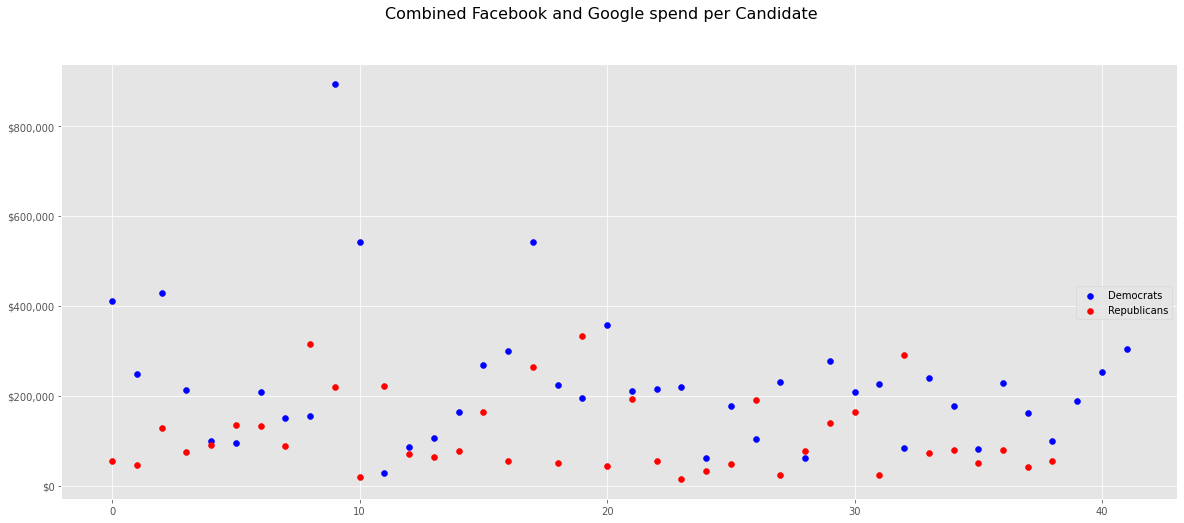

In [52]:
#FILTER TO ONLY BATTLEGROUND SEATS
dem = dem[ dem.battleground == True ]
rep = rep[ rep.battleground == True ]

fig, ax1 = plt.subplots()
ax1.scatter(range(len(dem)), dem.fbandg_since010619.tolist(), color='blue', label='Democrats')
ax1.scatter(range(len(rep)), rep.fbandg_since010619.tolist(), color='red', label='Republicans')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
fig.legend(loc=1, bbox_to_anchor=(1,0.5), bbox_transform=ax1.transAxes)
fig.suptitle( 'Combined Facebook and Google spend per Candidate', fontsize=16 )
plt.show()

In [53]:
# DEMOCRATS -> Descriptive statistics for digital media spend per candidate
dem.fbandg_since010619.describe()

count       42.00000
mean    227321.90476
std     157474.84983
min      28947.00000
25%     118088.25000
50%     210503.50000
75%     252503.25000
max     894569.00000
Name: fbandg_since010619, dtype: float64

In [54]:
# REPUBLICANS -> Descriptive statistics for digital media spend per candidate
rep.fbandg_since010619.describe()

count       39.00000
mean    110076.43590
std      85742.76070
min      15045.00000
25%      50386.50000
50%      77426.00000
75%     152374.00000
max     332936.00000
Name: fbandg_since010619, dtype: float64

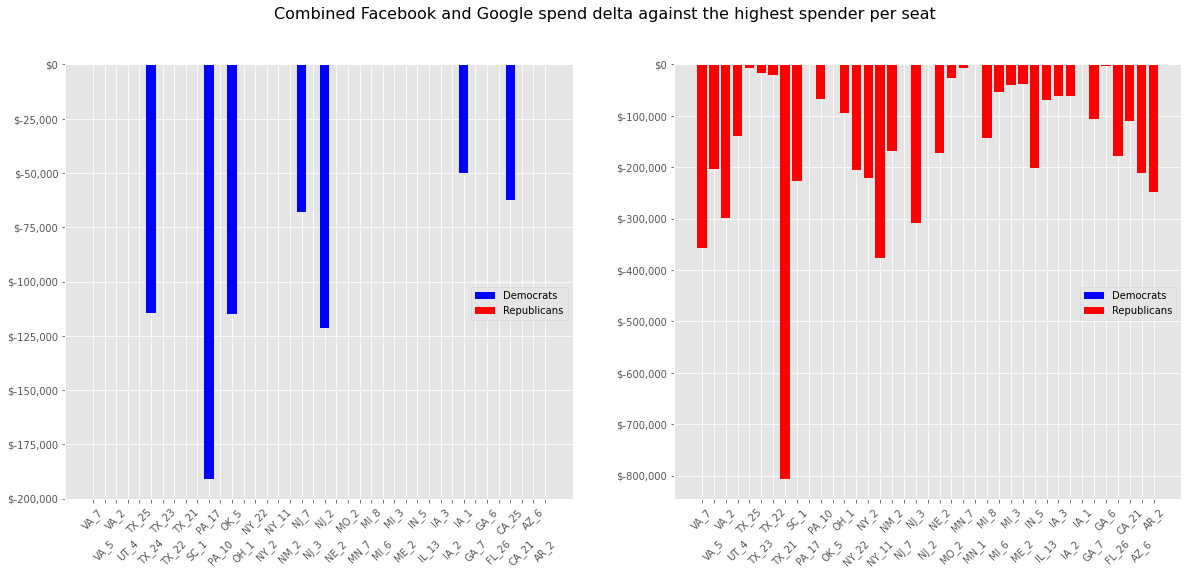

In [55]:
fig, ax1 = plt.subplots( nrows=1, ncols=2 )
plt.rcParams[ 'figure.figsize' ] = [ 20, 8 ]
plt.style.use('ggplot')

ax1[ 0 ].bar( dem.seat, dem.diff_from_max, color='blue', label='Democrats' )
ax1[ 1 ].bar( rep.seat, rep.diff_from_max, color='red', label='Republicans' )

for i in range( 2 ):
    #ax1[ i ].xaxis.set_major_locator(MaxNLocator(float=True))
    #ax1[ i ].ticklabel_format(useOffset=False, style='plain')

    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax1[ i ].yaxis.set_major_formatter(tick)
    
    plt.setp(ax1[ i ].xaxis.get_majorticklabels(), rotation=45)
    
    for tick in ax1[ i ].xaxis.get_major_ticks()[1::2]:
        tick.set_pad( 35 )
        
    fig.legend(loc=1, bbox_to_anchor=(1,0.5), bbox_transform=ax1[ i ].transAxes)
    
fig.suptitle( 'Combined Facebook and Google spend delta against the highest spender per seat', fontsize=16 )

plt.show()